# Bayesian Optimization with Random Forests (SMAC)

#### Optimizing a CNN with Scikit-Optimize
In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package Scikit-Optimize.

We will use Random Forests as the surrogate function to approximate f(x)

The MNIST dataset is availale in Kaggle.

#### Download dataset
* Navigate to the MNIST website in Kaggle
* Download the train.csv file
* Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
* Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

#### Notebook content
* Data Preparation
* Set up a simple CNN
* Set up the hyperparameter search shape
* Set up the objective function
* Perform Bayesian Optimization
* Evaluate Model Performance

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [1]:
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import forest_minimize, gbrt_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

## Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image.

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format).

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [2]:
# Load the data

data = pd.read_csv("../../data/processed/mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

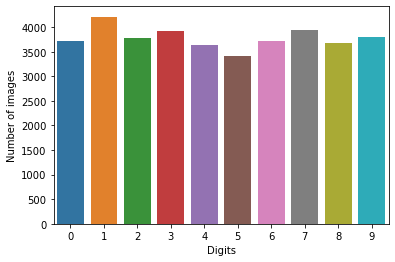

In [4]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [5]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

### Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel.

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices.

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [6]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### Target encoding

In [7]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1])

In [8]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

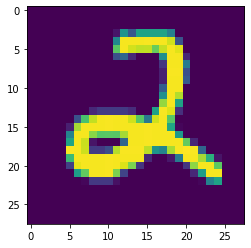

In [9]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

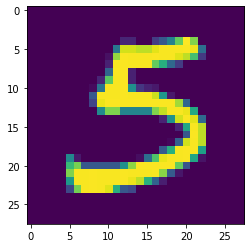

In [10]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

### Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [11]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in skopt.Space

We want to find the following hyper-parameters:

* The learning rate of the optimizer.
* The number of convolutional layers.
* The number of fully-connected Dense layers.
* The number of nodes (neurons) for each of the dense layers.
* Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [12]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_conv_layers = Integer(low=1, high=3, name='num_conv_layers')

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [13]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_conv_layers = Integer(low=1, high=3, name='num_conv_layers')

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [16]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_conv_layers,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

### Define the Objective Function

In [17]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [18]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_conv_layers:', num_conv_layers)
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_conv_layers=num_conv_layers,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

### Test run

In [19]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = [1e-5, 1, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_conv_layers: 1
num_dense_layers: 1
num_dense_nodes: 16
activation: relu



2022-09-07 06:24:07.230323: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 21s 76ms/step - loss: 2.2682 - accuracy: 0.2181 - val_loss: 2.2198 - val_accuracy: 0.3963 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 26s 98ms/step - loss: 2.1471 - accuracy: 0.4848 - val_loss: 2.0588 - val_accuracy: 0.5317 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 25s 95ms/step - loss: 1.9333 - accuracy: 0.5471 - val_loss: 1.7911 - val_accuracy: 0.5579 - lr: 1.0000e-05

Accuracy: 55.79%



-0.5579364895820618

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

### Bayesian Optimization with Random Forests

* forest_minimize
* gbrt_minimize

In [20]:
# we approximate f(x) using Random Forests, we could
# also approximate it with gradient boosting machines
# using gbrt_minimize instead.

fm_ = forest_minimize(
    objective,  # the objective function to minimize
    param_grid,  # the hyperparameter space
    x0=default_parameters,  # the initial parameters to test
    acq_func='EI',  # the acquisition function
    n_calls=30,  # the number of subsequent evaluations of f(x)
    random_state=0,
)

learning rate: 1.0e-05
num_conv_layers: 1
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 25s 89ms/step - loss: 2.2664 - accuracy: 0.2312 - val_loss: 2.2187 - val_accuracy: 0.3950 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 25s 93ms/step - loss: 2.1416 - accuracy: 0.4844 - val_loss: 2.0523 - val_accuracy: 0.5093 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 23s 87ms/step - loss: 1.9355 - accuracy: 0.5447 - val_loss: 1.8069 - val_accuracy: 0.5632 - lr: 1.0000e-05

Accuracy: 56.32%

learning rate: 2.4e-04
num_conv_layers: 1
num_dense_layers: 4
num_dense_nodes: 256
activation: sigmoid

Epoch 1/3
266/266 [==============================] - 29s 105ms/step - loss: 2.3111 - accuracy: 0.1004 - val_loss: 2.3035 - val_accuracy: 0.1037 - lr: 2.3517e-04
Epoch 2/3
266/266 [==============================] - 26s 98ms/step - loss: 2.2105 - accuracy: 0.1807 - val_loss: 1.6648 - val_accuracy: 

/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 146s 547ms/step - loss: 0.2503 - accuracy: 0.9175 - val_loss: 0.1190 - val_accuracy: 0.9677 - lr: 0.0014
Epoch 2/3
266/266 [==============================] - 139s 523ms/step - loss: 0.0595 - accuracy: 0.9819 - val_loss: 0.0620 - val_accuracy: 0.9831 - lr: 0.0014
Epoch 3/3
266/266 [==============================] - 135s 507ms/step - loss: 0.0464 - accuracy: 0.9871 - val_loss: 0.0490 - val_accuracy: 0.9857 - lr: 0.0014

Accuracy: 98.57%

learning rate: 3.4e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 264
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 130s 475ms/step - loss: 0.4106 - accuracy: 0.8578 - val_loss: 0.1016 - val_accuracy: 0.9709 - lr: 0.0034
Epoch 2/3
266/266 [==============================] - 115s 433ms/step - loss: 0.0876 - accuracy: 0.9744 - val_loss: 0.0715 - val_accuracy: 0.9778 - lr: 0.0034
Epoch 3/3
266/266 [==============================] - 126s 472ms/step - loss: 0.0656 - accuracy: 0.9813 - val_loss: 0.0894 - val_accuracy: 0.9746 - lr: 0.0034

Accuracy: 97.46%

learning rate: 2.5e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 255
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 117s 439ms/step - loss: 2.3023 - accuracy: 0.1100 - val_loss: 2.3009 - val_accuracy: 0.1146 - lr: 0.0025
Epoch 2/3
266/266 [==============================] - 108s 405ms/step - loss: 2.3017 - accuracy: 0.1111 - val_loss: 2.3008 - val_accuracy: 0.1146 - lr: 0.0025
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3015 - accuracy: 0.1111
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0012450312497094274.
266/266 [==============================] - 113s 426ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3010 - val_accuracy: 0.1146 - lr: 0.0025

Accuracy: 11.46%

learning rate: 1.4e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 510
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 135s 505ms/step - loss: 0.2460 - accuracy: 0.9215 - val_loss: 0.0923 - val_accuracy: 0.9714 - lr: 0.0014
Epoch 2/3
266/266 [==============================] - 119s 447ms/step - loss: 0.0632 - accuracy: 0.9811 - val_loss: 0.0744 - val_accuracy: 0.9802 - lr: 0.0014
Epoch 3/3
266/266 [==============================] - 112s 420ms/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 0.0750 - val_accuracy: 0.9802 - lr: 0.0014

Accuracy: 98.02%

learning rate: 4.0e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 415
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 104s 389ms/step - loss: 0.5981 - accuracy: 0.7925 - val_loss: 0.1115 - val_accuracy: 0.9661 - lr: 0.0040
Epoch 2/3
266/266 [==============================] - 101s 380ms/step - loss: 0.1120 - accuracy: 0.9669 - val_loss: 0.0981 - val_accuracy: 0.9738 - lr: 0.0040
Epoch 3/3
266/266 [==============================] - 100s 376ms/step - loss: 0.0845 - accuracy: 0.9757 - val_loss: 0.0787 - val_accuracy: 0.9780 - lr: 0.0040

Accuracy: 97.80%

learning rate: 4.1e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 385
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 103s 384ms/step - loss: 0.5399 - accuracy: 0.8128 - val_loss: 0.1269 - val_accuracy: 0.9632 - lr: 0.0041
Epoch 2/3
266/266 [==============================] - 102s 382ms/step - loss: 0.0933 - accuracy: 0.9718 - val_loss: 0.0792 - val_accuracy: 0.9754 - lr: 0.0041
Epoch 3/3
266/266 [==============================] - 101s 378ms/step - loss: 0.0742 - accuracy: 0.9786 - val_loss: 0.1111 - val_accuracy: 0.9714 - lr: 0.0041

Accuracy: 97.14%

learning rate: 5.9e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 345
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 95s 355ms/step - loss: 2.3124 - accuracy: 0.1094 - val_loss: 2.3017 - val_accuracy: 0.0997 - lr: 0.0059
Epoch 2/3
266/266 [==============================] - 100s 375ms/step - loss: 2.3018 - accuracy: 0.1079 - val_loss: 2.3015 - val_accuracy: 0.1146 - lr: 0.0059
Epoch 3/3
266/266 [==============================] - 86s 323ms/step - loss: 2.3018 - accuracy: 0.1108 - val_loss: 2.3018 - val_accuracy: 0.1146 - lr: 0.0059

Accuracy: 11.46%

learning rate: 2.4e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 427
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 120s 450ms/step - loss: 0.3043 - accuracy: 0.9033 - val_loss: 0.1041 - val_accuracy: 0.9725 - lr: 0.0024
Epoch 2/3
266/266 [==============================] - 144s 543ms/step - loss: 0.0694 - accuracy: 0.9803 - val_loss: 0.0955 - val_accuracy: 0.9754 - lr: 0.0024
Epoch 3/3
266/266 [==============================] - 113s 424ms/step - loss: 0.0557 - accuracy: 0.9839 - val_loss: 0.0895 - val_accuracy: 0.9847 - lr: 0.0024

Accuracy: 98.47%

learning rate: 9.9e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 430
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 97s 364ms/step - loss: 2.3094 - accuracy: 0.1084 - val_loss: 2.3010 - val_accuracy: 0.1146 - lr: 0.0099
Epoch 2/3
266/266 [==============================] - 99s 371ms/step - loss: 2.3020 - accuracy: 0.1085 - val_loss: 2.3018 - val_accuracy: 0.1146 - lr: 0.0099
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3019 - accuracy: 0.1095
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004929480142891407.
266/266 [==============================] - 92s 346ms/step - loss: 2.3019 - accuracy: 0.1095 - val_loss: 2.3011 - val_accuracy: 0.1146 - lr: 0.0099

Accuracy: 11.46%

learning rate: 1.9e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 438
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 111s 413ms/step - loss: 0.2823 - accuracy: 0.9075 - val_loss: 0.0805 - val_accuracy: 0.9783 - lr: 0.0019
Epoch 2/3
266/266 [==============================] - 102s 383ms/step - loss: 0.0670 - accuracy: 0.9804 - val_loss: 0.0866 - val_accuracy: 0.9772 - lr: 0.0019
Epoch 3/3
266/266 [==============================] - 110s 413ms/step - loss: 0.0525 - accuracy: 0.9841 - val_loss: 0.0652 - val_accuracy: 0.9833 - lr: 0.0019

Accuracy: 98.33%

learning rate: 2.8e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 477
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 112s 419ms/step - loss: 0.4226 - accuracy: 0.8519 - val_loss: 0.0948 - val_accuracy: 0.9730 - lr: 0.0028
Epoch 2/3
266/266 [==============================] - 103s 389ms/step - loss: 0.0771 - accuracy: 0.9777 - val_loss: 0.0764 - val_accuracy: 0.9799 - lr: 0.0028
Epoch 3/3
266/266 [==============================] - 104s 392ms/step - loss: 0.0653 - accuracy: 0.9820 - val_loss: 0.0661 - val_accuracy: 0.9786 - lr: 0.0028

Accuracy: 97.86%

learning rate: 2.2e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 432
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 104s 388ms/step - loss: 0.3538 - accuracy: 0.8796 - val_loss: 0.1144 - val_accuracy: 0.9667 - lr: 0.0022
Epoch 2/3
266/266 [==============================] - 103s 386ms/step - loss: 0.0641 - accuracy: 0.9812 - val_loss: 0.0706 - val_accuracy: 0.9817 - lr: 0.0022
Epoch 3/3
266/266 [==============================] - 101s 378ms/step - loss: 0.0507 - accuracy: 0.9850 - val_loss: 0.0818 - val_accuracy: 0.9820 - lr: 0.0022

Accuracy: 98.20%

learning rate: 3.2e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 422
activation: relu



/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 99s 369ms/step - loss: 0.3953 - accuracy: 0.8639 - val_loss: 0.1127 - val_accuracy: 0.9664 - lr: 0.0032
Epoch 2/3
266/266 [==============================] - 97s 366ms/step - loss: 0.0817 - accuracy: 0.9760 - val_loss: 0.0959 - val_accuracy: 0.9757 - lr: 0.0032
Epoch 3/3
266/266 [==============================] - 96s 362ms/step - loss: 0.0612 - accuracy: 0.9820 - val_loss: 0.0884 - val_accuracy: 0.9765 - lr: 0.0032

Accuracy: 97.65%

learning rate: 3.8e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 451
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 99s 371ms/step - loss: 0.4177 - accuracy: 0.8555 - val_loss: 0.1034 - val_accuracy: 0.9709 - lr: 0.0038
Epoch 2/3
266/266 [==============================] - 95s 357ms/step - loss: 0.0863 - accuracy: 0.9732 - val_loss: 0.0780 - val_accuracy: 0.9767 - lr: 0.0038
Epoch 3/3
266/266 [==============================] - 96s 360ms/step - loss: 0.0774 - accuracy: 0.9781 - val_loss: 0.0735 - val_accuracy: 0.9810 - lr: 0.0038

Accuracy: 98.10%

learning rate: 2.9e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 409
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 100s 373ms/step - loss: 0.4805 - accuracy: 0.8318 - val_loss: 0.0870 - val_accuracy: 0.9738 - lr: 0.0029
Epoch 2/3
266/266 [==============================] - 104s 390ms/step - loss: 0.0829 - accuracy: 0.9745 - val_loss: 0.0797 - val_accuracy: 0.9775 - lr: 0.0029
Epoch 3/3
266/266 [==============================] - 102s 384ms/step - loss: 0.0600 - accuracy: 0.9823 - val_loss: 0.0559 - val_accuracy: 0.9852 - lr: 0.0029

Accuracy: 98.52%

learning rate: 4.7e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 446
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 102s 381ms/step - loss: 2.3050 - accuracy: 0.1084 - val_loss: 2.3007 - val_accuracy: 0.1146 - lr: 0.0047
Epoch 2/3
266/266 [==============================] - 92s 345ms/step - loss: 2.3017 - accuracy: 0.1111 - val_loss: 2.3012 - val_accuracy: 0.1146 - lr: 0.0047
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3015 - accuracy: 0.1111
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0023435279726982117.
266/266 [==============================] - 93s 348ms/step - loss: 2.3015 - accuracy: 0.1111 - val_loss: 2.3014 - val_accuracy: 0.1146 - lr: 0.0047

Accuracy: 11.46%

learning rate: 3.5e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 428
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 97s 363ms/step - loss: 0.5966 - accuracy: 0.7858 - val_loss: 0.1927 - val_accuracy: 0.9458 - lr: 0.0035
Epoch 2/3
266/266 [==============================] - 98s 369ms/step - loss: 0.1086 - accuracy: 0.9673 - val_loss: 0.1242 - val_accuracy: 0.9622 - lr: 0.0035
Epoch 3/3
266/266 [==============================] - 96s 362ms/step - loss: 0.0753 - accuracy: 0.9772 - val_loss: 0.0951 - val_accuracy: 0.9728 - lr: 0.0035

Accuracy: 97.28%

learning rate: 2.3e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 395
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 102s 384ms/step - loss: 0.3027 - accuracy: 0.8977 - val_loss: 0.0897 - val_accuracy: 0.9746 - lr: 0.0023
Epoch 2/3
266/266 [==============================] - 102s 385ms/step - loss: 0.0690 - accuracy: 0.9797 - val_loss: 0.0627 - val_accuracy: 0.9817 - lr: 0.0023
Epoch 3/3
266/266 [==============================] - 109s 411ms/step - loss: 0.0549 - accuracy: 0.9844 - val_loss: 0.0568 - val_accuracy: 0.9849 - lr: 0.0023

Accuracy: 98.49%

learning rate: 3.5e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 455
activation: relu

Epoch 1/3


/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


266/266 [==============================] - 105s 394ms/step - loss: 0.6591 - accuracy: 0.7645 - val_loss: 0.1208 - val_accuracy: 0.9683 - lr: 0.0035
Epoch 2/3
266/266 [==============================] - 99s 373ms/step - loss: 0.0907 - accuracy: 0.9735 - val_loss: 0.0961 - val_accuracy: 0.9746 - lr: 0.0035
Epoch 3/3
266/266 [==============================] - 103s 388ms/step - loss: 0.0697 - accuracy: 0.9796 - val_loss: 0.0622 - val_accuracy: 0.9823 - lr: 0.0035

Accuracy: 98.23%



### Analyze results

In [21]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % fm_.fun

'Best score=-0.9857'

In [22]:
fm_.x

[0.0013632546295566314, 3, 3, 440, 'relu']

In [23]:
fm_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='identity'),
       Integer(low=1, high=3, prior='uniform', transform='identity'),
       Integer(low=1, high=5, prior='uniform', transform='identity'),
       Integer(low=5, high=512, prior='uniform', transform='identity'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [24]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_conv_laayers=%d
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" %(
    fm_.x[0], 
    fm_.x[1],
    fm_.x[2],
    fm_.x[3],
    fm_.x[4],
))

Best parameters:
- learning rate=0.001363
- num_conv_laayers=3
- num_dense_layers=3
- num_nodes=440
- activation = relu


### Convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

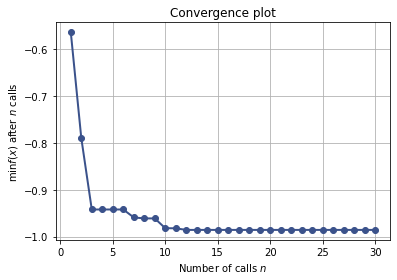

In [25]:
plot_convergence(fm_)

### Partially dependency plots

In [26]:
dim_names = ['learning_rate', 'num_conv_layers', 'num_dense_layers', 'num_dense_nodes', 'activation']

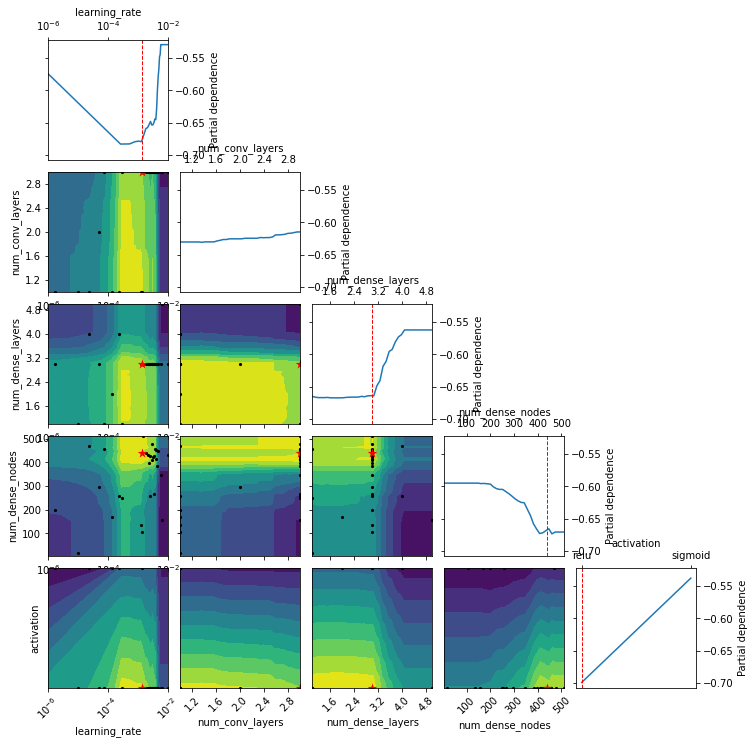

In [27]:
plot_objective(result=fm_, plot_dims=dim_names)
plt.show()

### Evaluation order

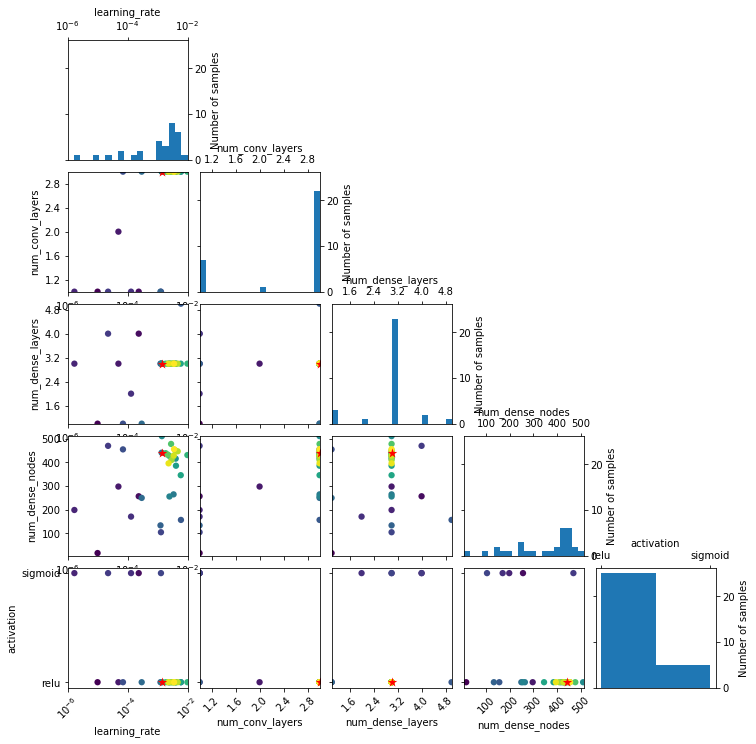

In [28]:
plot_evaluations(result=fm_, plot_dims=dim_names)
plt.show()

### Evaluate the model

In [29]:
# load best model

model = load_model(path_best_model)

In [30]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 4s 29ms/step - loss: 0.0474 - accuracy: 0.9864


In [31]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04738698527216911
accuracy 0.9864285588264465


### Confusion matrix

In [33]:
import numpy as np

In [34]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[421,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 471,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0,   0, 406,   0,   0,   0,   0,   3,   0,   0],
       [  2,   0,   4, 416,   0,   2,   0,   1,   0,   1],
       [  1,   0,   0,   0, 426,   0,   1,   0,   0,   1],
       [  0,   0,   0,   2,   0, 376,   3,   0,   0,   1],
       [  0,   0,   0,   0,   2,   0, 410,   0,   0,   0],
       [  0,   2,   5,   0,   0,   0,   0, 461,   0,   1],
       [  0,   1,   3,   0,   0,   0,   4,   0, 376,   0],
       [  3,   1,   1,   0,   8,   0,   0,   0,   1, 380]])

Text(0.5, 13.421126458070283, 'Predicted label')

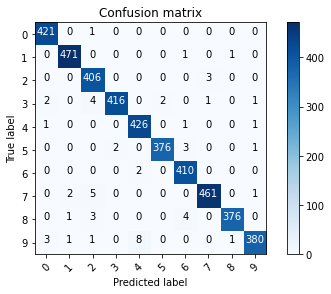

In [35]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

### Exploring the Scikit-Optimize minimizer

In [36]:
fm_

          fun: -0.9857142567634583
    func_vals: array([-0.56322753, -0.78941798, -0.94206351, -0.09973545, -0.69576722,
       -0.11455026, -0.95899469, -0.96111113, -0.11455026, -0.9820106 ,
       -0.98227513, -0.98571426, -0.97460318, -0.11455026, -0.98015875,
       -0.9780423 , -0.97142857, -0.11455026, -0.9846561 , -0.11455026,
       -0.98333335, -0.97857141, -0.9820106 , -0.97645503, -0.98095238,
       -0.98518521, -0.11455026, -0.97275132, -0.98492062, -0.98227513])
       models: [ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_stat

In [38]:
# the accuracy

fm_.func_vals

array([-0.56322753, -0.78941798, -0.94206351, -0.09973545, -0.69576722,
       -0.11455026, -0.95899469, -0.96111113, -0.11455026, -0.9820106 ,
       -0.98227513, -0.98571426, -0.97460318, -0.11455026, -0.98015875,
       -0.9780423 , -0.97142857, -0.11455026, -0.9846561 , -0.11455026,
       -0.98333335, -0.97857141, -0.9820106 , -0.97645503, -0.98095238,
       -0.98518521, -0.11455026, -0.97275132, -0.98492062, -0.98227513])

In [39]:
# the hyperparameter combinations

fm_.x_iters

[[1e-05, 1, 1, 16, 'relu'],
 [0.00023516813385771865, 1, 4, 256, 'sigmoid'],
 [4.950159553733197e-05, 2, 3, 297, 'relu'],
 [1.6859780231705853e-06, 1, 3, 198, 'sigmoid'],
 [0.00013049073550362405, 1, 2, 170, 'sigmoid'],
 [2.2365810539197545e-05, 1, 4, 469, 'sigmoid'],
 [0.0012960656597279748, 1, 3, 104, 'sigmoid'],
 [7.01321977994579e-05, 3, 1, 454, 'relu'],
 [0.006007249475906207, 3, 5, 156, 'relu'],
 [0.0012500712230836273, 1, 3, 133, 'relu'],
 [0.0002954894558726686, 3, 1, 249, 'relu'],
 [0.0013632546295566314, 3, 3, 440, 'relu'],
 [0.003413986150958144, 3, 3, 264, 'relu'],
 [0.0024900626005720516, 3, 3, 255, 'relu'],
 [0.001390303556782622, 3, 3, 510, 'relu'],
 [0.00401826295889157, 3, 3, 415, 'relu'],
 [0.0041051504973534285, 3, 3, 385, 'relu'],
 [0.005923968800474911, 3, 3, 345, 'relu'],
 [0.002436705352562109, 3, 3, 427, 'relu'],
 [0.009858960267281764, 3, 3, 430, 'relu'],
 [0.0018583009690171632, 3, 3, 438, 'relu'],
 [0.002818440353793694, 3, 3, 477, 'relu'],
 [0.00218864210785

In [40]:
# all together in one dataframe, so we can investigate further

tmp = pd.concat([
    pd.DataFrame(fm_.x_iters),
    pd.Series(fm_.func_vals),
], axis=1)

tmp.columns = dim_names + ['accuracy']
tmp.head()

,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,activation,accuracy
0,0.000010,1,1,16,relu,-0.563228
1,0.000235,1,4,256,sigmoid,-0.789418
2,0.000050,2,3,297,relu,-0.942064
3,0.000002,1,3,198,sigmoid,-0.099735
4,0.000130,1,2,170,sigmoid,-0.695767


In [41]:
tmp.sort_values(by='accuracy', ascending=True, inplace=True)
tmp.head(10)

,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,activation,accuracy
11,0.001363,3,3,440,relu,-0.985714
25,0.002908,3,3,409,relu,-0.985185
28,0.002325,3,3,395,relu,-0.984921
18,0.002437,3,3,427,relu,-0.984656
20,0.001858,3,3,438,relu,-0.983333
29,0.003542,3,3,455,relu,-0.982275
10,0.000295,3,1,249,relu,-0.982275
22,0.002189,3,3,432,relu,-0.982011
9,0.001250,1,3,133,relu,-0.982011
24,0.003809,3,3,451,relu,-0.980952
